In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [5]:
df = pd.read_csv("cleaned_heart_disease_data.csv")
X = df.drop(columns=['num'])
df['num'] = np.where(df['num']>0,1,0)
y = df['num']

In [6]:
X = df.drop(columns=['num','chol','trestbps'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# K-means 


K=2: WCSS=77126.94, Silhouette Score=0.479
K=3: WCSS=48820.37, Silhouette Score=0.399
K=4: WCSS=37863.75, Silhouette Score=0.356
K=5: WCSS=31092.65, Silhouette Score=0.336
K=6: WCSS=26185.52, Silhouette Score=0.351
K=7: WCSS=23330.35, Silhouette Score=0.346
K=8: WCSS=20722.32, Silhouette Score=0.318
K=9: WCSS=18535.83, Silhouette Score=0.325
K=10: WCSS=16357.05, Silhouette Score=0.330


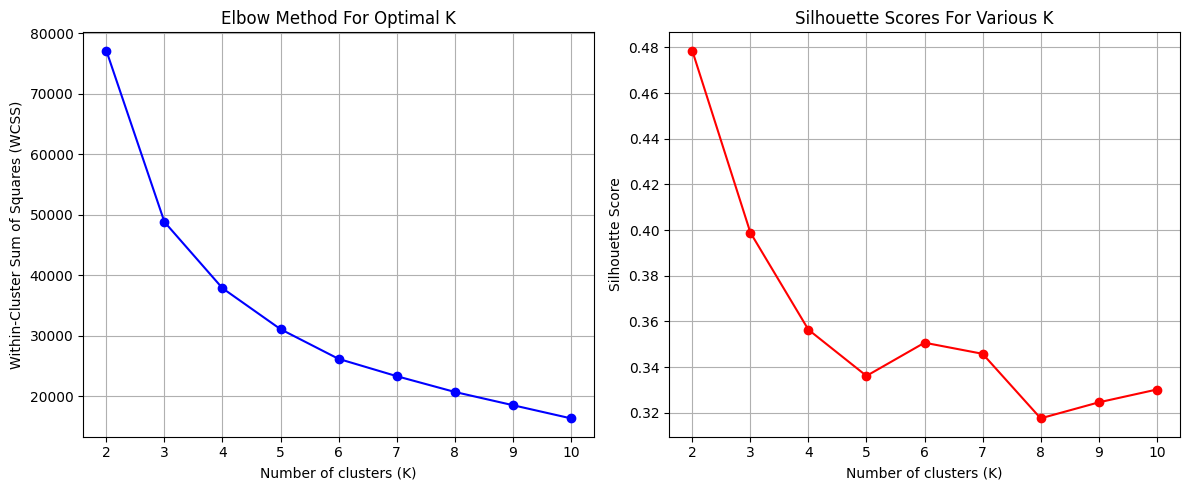

In [9]:


# Define range of K values to test
k_range = range(2, 11)  
wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []  # Silhouette scores

# Calculate WCSS and silhouette score for each K
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, max_iter=300, n_init=10)
    labels = kmeans.fit_predict(X)
    
    wcss.append(kmeans.inertia_)  # inertia_: sum of squared distances to cluster centers
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}: WCSS={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.3f}")

# Plot Elbow method graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-', markersize=6)
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', markersize=6)
plt.title('Silhouette Scores For Various K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Fit final KMeans with optimal_k and assign clusters
optimal_k = 2
final_kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, max_iter=300, n_init=10)
df['Cluster Label'] = final_kmeans.fit_predict(X)

# Calculate silhouette score
sil_score = silhouette_score(X, df['Cluster Label'])
print(f"Silhouette Score = {sil_score:.3f}")

# Display mean feature values per cluster
print(df.groupby('Cluster Label').mean(),'\n')

# Evaluate clustering quality
if sil_score >= 0.45:  # Above 0.45 is good
    print("Approved Score ---> Good Clustering\n")
elif sil_score >= 0.25:  # Above 0.25 is not that good but not bad though
    print("Approved Score ---> Not Bad Clustering\n")
else:  # Unacceptable
    print("Not Approved ----> Weak Clustering\n")

Silhouette Score = 0.479
                     age       sex        cp    trestbps        chol  \
Cluster Label                                                          
0              57.788618  0.739837  3.495935  132.186992  242.642276   
1              52.150000  0.638889  2.927778  130.772222  247.594444   

                    fbs   restecg     thalach     exang   oldpeak     slope  \
Cluster Label                                                                 
0              0.146341  1.089431  127.016260  0.552846  1.571545  1.878049   
1              0.150000  0.922222  165.044444  0.172222  0.650556  1.411111   

                     ca      thal       num  
Cluster Label                                
0              0.951220  5.455285  0.707317  
1              0.466667  4.222222  0.288889   

Approved Score ---> Good Clustering



#  Hierarchical Clustering 


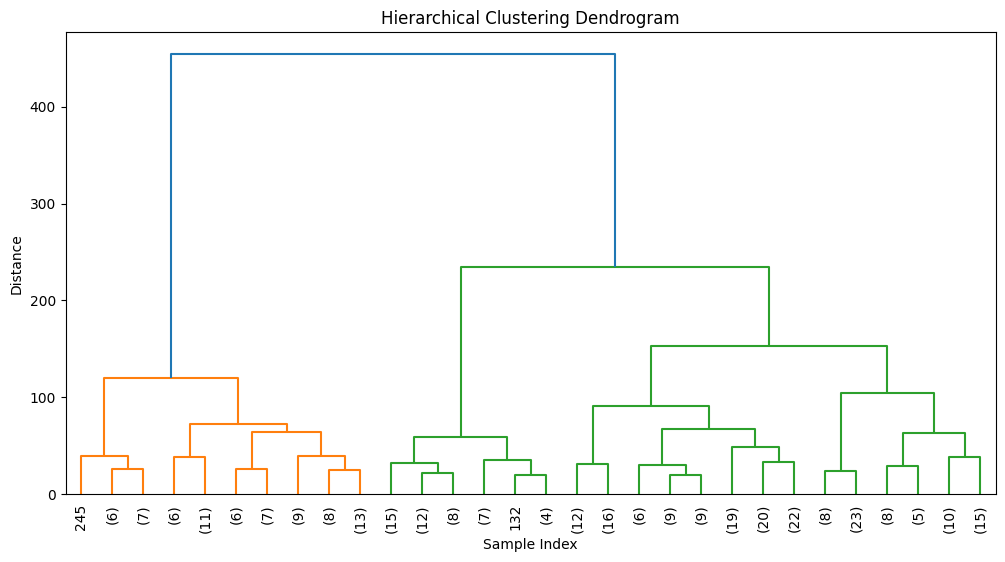

                     age       sex        cp    trestbps        chol  \
Cluster Label                                                          
0              53.004367  0.663755  3.017467  131.069869  246.445415   
1              58.878378  0.729730  3.594595  132.202703  242.918919   

                    fbs   restecg     thalach     exang   oldpeak     slope  \
Cluster Label                                                                 
0              0.152838  0.938865  159.991266  0.240175  0.849782  1.502183   
1              0.135135  1.148649  117.472973  0.594595  1.564865  1.905405   

                     ca      thal       num  
Cluster Label                                
0              0.532751  4.528384  0.366812  
1              1.067568  5.324324  0.743243  


In [12]:
# Compute linkage matrix for dendrogram
linkage_matrix = linkage(X, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10)
plt.show()

# Perform Agglomerative Clustering with the fixed parameters
n_clusters = 2
agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean')
labels = agg_cluster.fit_predict(X)

# Add cluster labels to dataframe
df['Cluster Label'] = labels

# Display means per cluster
print(df.groupby('Cluster Label').mean())


In [14]:
# Evaluate clustering quality with multiple metrics
sil_score = silhouette_score(X, labels)
db_score = davies_bouldin_score(X, labels)
ch_score = calinski_harabasz_score(X, labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

Silhouette Score: 0.503
Davies-Bouldin Index: 0.669
Calinski-Harabasz Index: 378.026


In [15]:
# Evaluate clustering quality with silhouette score interpretation
if sil_score >= 0.70:
    print("Excellent clustering - strong structure found (silhouette score >= 0.70)\n")
elif sil_score >= 0.50:
    print("Good clustering - reasonable structure found (silhouette score >= 0.50)\n")
elif sil_score >= 0.25:
    print("Fair clustering - weak structure, consider review (silhouette score >= 0.25)\n")
else:
    print("Poor clustering - no substantial structure detected (silhouette score < 0.25)\n")


# Evaluate Davies-Bouldin Index with interpretation
if db_score < 0.5:
    print(f"Davies-Bouldin Index: {db_score:.3f} - Excellent clustering")
elif db_score < 1.0:
    print(f"Davies-Bouldin Index: {db_score:.3f} - Good clustering")
else:
    print(f"Davies-Bouldin Index: {db_score:.3f} - Poor clustering")

# Evaluate Calinski-Harabasz Index with interpretation (relative scale)
if ch_score > 1000:
    print(f"Calinski-Harabasz Index: {ch_score:.1f} - Very good clustering")
elif ch_score > 300:
    print(f"Calinski-Harabasz Index: {ch_score:.1f} - Good clustering")
else:
    print(f"Calinski-Harabasz Index: {ch_score:.1f} - Weak clustering")

Good clustering - reasonable structure found (silhouette score >= 0.50)

Davies-Bouldin Index: 0.669 - Good clustering
Calinski-Harabasz Index: 378.0 - Good clustering


# Clustering models with visualized results 


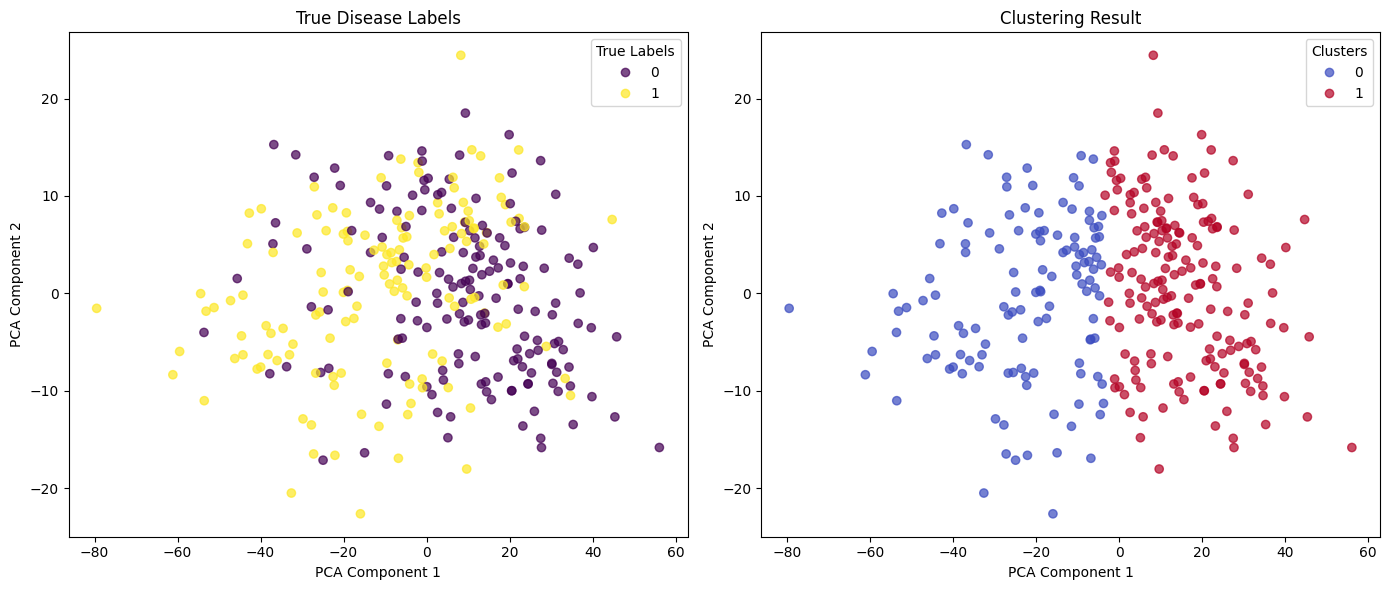

In [16]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
pred_labels = kmeans.fit_predict(X)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot true labels
scatter1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0].set_title("True Disease Labels")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(*scatter1.legend_elements(), title="True Labels")

# Plot predicted/cluster labels
scatter2 = axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=pred_labels, cmap='coolwarm', alpha=0.7)
axes[1].set_title("Clustering Result")
axes[1].set_xlabel("PCA Component 1")
axes[1].set_ylabel("PCA Component 2")
axes[1].legend(*scatter2.legend_elements(), title="Clusters")

plt.tight_layout()
plt.show()
